Best fitness:
Ecosystem: textual ecosystem to be inhabited simulating environment
Genom:     _______________________ inhabited simulating environm___      Generation: 49
Finished!


<IPython.core.display.Javascript object>


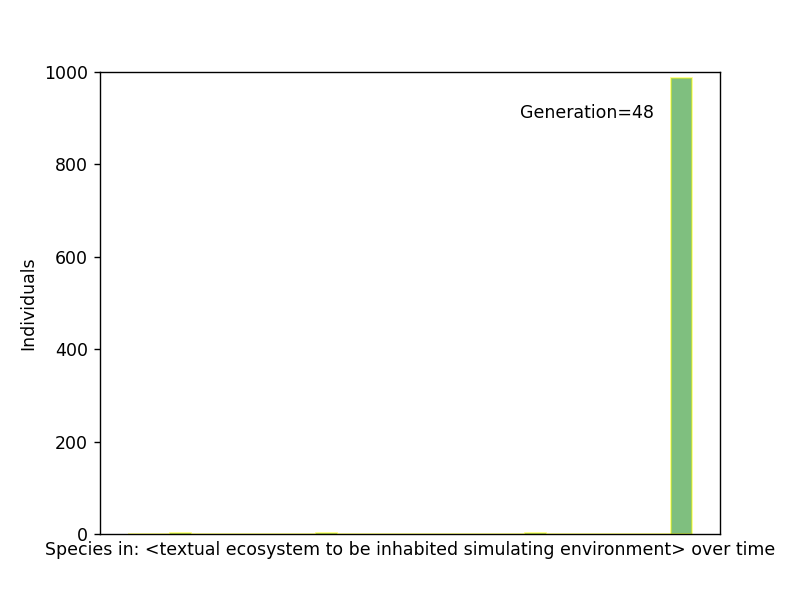

In [34]:
import random
import string
import jellyfish
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib.animation import FuncAnimation

ecosystem = "textual ecosystem to be inhabited simulating environment"
population_size = 1000
genome_length = 30
letters = string.ascii_letters[:26] + " " 
cache = {}
generations = 100
printing_best_competitors = True


def generate_initial_population(genome_length, population_size):
    """
    Generating list of genomes in initial population.
    """
    population = []
    
    for i in range(population_size):
        mutation = ""
        for j in range(genome_length):
            mutation += random.choice(letters)

        population.append(mutation)
    
    return population


def individual_fitness(genome):  
    """
    Computes best fitness a niche/species of an organism in the ecosystem
    inptut: genome of an organism
    output: fitness, species
    """
    maxfitness = 0
    species = 0
    
    for niche in range(len(ecosystem) - genome_length + 1):
        fitness = genome_length - jellyfish.levenshtein_distance(genome, ecosystem[niche:niche + genome_length])
        if fitness > maxfitness:
            maxfitness = fitness
            species = niche
            
    return maxfitness, species 


def global_fitness(population): 
    """
    Fitness of all organism.
    Output: list of all fitness and species in a given population
    """
    population_fitness = []
    population_species = []
    
    for genome in population:
        ind_fitness, species = individual_fitness(genome)
        population_fitness.append(ind_fitness)
        population_species.append(species)
    return population_fitness, population_species


def mating (population, population_fitness, population_species):
    """
    Function takes list of population members and list of their corresponding
    scores, and returns 2 members with the highest scores
    Input: three lists, describing population (genome, fitness and species)
    """
    panmictic_list = list(range(len(population)))
    random.shuffle(panmictic_list)
    
    for mother in range(population_size):
        for father in panmictic_list:
            if father!= mother:
                if population_species[mother] == population_species[father]:
                    new_orgs, new_fitness, new_species = offsprings(mother, father, population, population_fitness)
                    population.extend(new_orgs)
                    population_fitness.extend(new_fitness)
                    population_species.extend(new_species)
                    break
      

def offsprings (mother_index, father_index, population, population_fitness):
    """
    Given parents' indexes, we produce a subpopulation of offsprings. Each of their genomes is
    cross-over from parents' genome. The amount of offsprings is based on parents' fitnesses product, 
    normalized by average fitness.
    Two types of mutations are incorporated - substitution (regular) and insertion/deletion (stochastic). 
    Loci of substitution, insertion as well as deletion are chosen randomly.
    Output - three lists describing genome, fitness and species of the subpopulation of offsprings.
    """
    
    cross = random.randint(0,genome_length-1)
    offsprings = []
    average_fitness = sum(population_fitness)/len(population_fitness)
    num_offsprings = int(population_fitness[mother_index] * population_fitness[father_index] / (2 * average_fitness))
    
    for off in range(num_offsprings):
        off = population[mother_index][:cross] + population[father_index][cross:]
        mutation_position = random.randint(0,genome_length - 1)
        off = off[:mutation_position] + random.choice(letters) + off[mutation_position + 1:]
        if random.randint(0,10) > 9:
            deletion_position = random.randint(0,genome_length)
            insertion_position = random.randint(0,genome_length - 1)
            off = off[:insertion_position] + random.choice(letters) + off[insertion_position:]
            off = off[:deletion_position] + off[deletion_position + 1:]
            
        offsprings.append(off)
    
    offspring_fitness, offspring_species = global_fitness(offsprings)

    return offsprings, offspring_fitness, offspring_species


def selection (population, population_fitness, population_species):
    """
    Reducing population to population_size via deterministic selection based on fitness-order.
    """
    
    fitness_order = population_fitness.copy()
    fitness_order.sort()

    fitness_order.reverse()
    
    fitness_to_survive = fitness_order[min(population_size, len(population))]
    
    for i in reversed(range(len(population))):
        if population_fitness[i] <= fitness_to_survive:
            population.pop(i)
            population_fitness.pop(i)
            population_species.pop(i)
        if len(population) <= population_size:
            break

def evolution(cache):
    """
    Main function for twisting between reproduction (including mutations) and selection.
    """

    population = generate_initial_population (genome_length, population_size)
    population_fitness, population_species = global_fitness(population)
    cache['g'] = population_species.copy()
    
    print("Best fitness:")
    print("Ecosystem: " + ecosystem)
    
    for generation in range(generations):
        mating (population, population_fitness, population_species)
        selection (population, population_fitness, population_species)
        cache['g' + str(generation)] = population_species.copy()
        
        best_fitness = max(population_fitness)
        best_organism = population[population_fitness.index(best_fitness)]
        best_species = population_species[population_fitness.index(best_fitness)]
         
        # printing the individual with the highest fitness.
        
        if printing_best_competitors:
            print('Genom:     ' + best_species * '_' 
                  + best_organism
                  + (len(ecosystem) - best_species - genome_length) * '_'
                  + '      Generation: ' + str(generation), end = '\r')
        
        if best_fitness == genome_length:
            print('\nFinished!')
            return generation

last_generation = evolution(cache)

HIST_BINS = len(ecosystem) - genome_length + 1
data = cache['g']
n, _ = np.histogram(data, HIST_BINS)

def prepare_animation(bar_container):

    def animate(frame_num): 
        plt.cla()
        data = cache['g' + str(frame_num)]
        _, _, bar_container = ax.hist(data, HIST_BINS, lw=1,
                                    ec="yellow", fc="green", alpha=0.5)

        ax.set_ylim(top=1000)
        ax.set_xlabel("Species in: <" + ecosystem + "> over time")
        ax.set_ylabel("Individuals")

        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        n, _ = np.histogram(data, HIST_BINS)

        ax.annotate('Generation={}'.format(frame_num), [len(ecosystem) - genome_length - 10, int(0.9 * population_size)])
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        return bar_container.patches
    return animate

fig, ax = plt.subplots()
ani = FuncAnimation(fig, prepare_animation(bar_container), frames = last_generation, interval = 400,
                                      repeat=False)
plt.show()
